# 神经网络反向传播及隐藏层可视化(手写数据集)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio  #读取.mat文件
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # (5000)

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])  #(5000,400)

    return X, y
    
pathFile = './ex4data1.mat'
X,_ = load_data(pathFile)



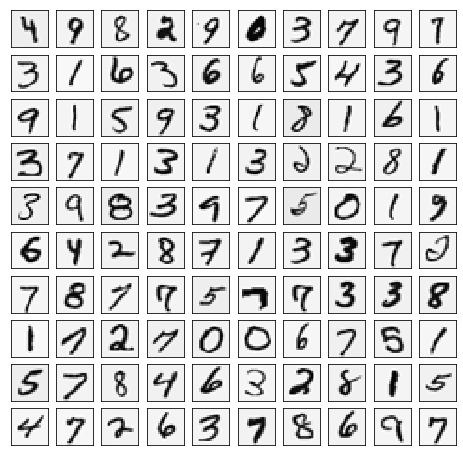

In [3]:
#训练数据集可视化
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()
    return None
plot_100_image(X)



## 1.准备数据集X和y

In [4]:
X_raw, y_raw = load_data('ex4data1.mat', transpose=False)
X = np.c_[np.ones((X_raw.shape[0],1)),X_raw]  #在第一列的位置添加偏差列
print(X.shape)

(5000, 401)


In [5]:
#OneHot标签
def OneHot(y):
    result = []
    for label in y:
        new = np.zeros(10)
        new[label-1] = 1
        result.append(new)
    return np.array(result)

y = OneHot(y_raw)
print('OneHot之后的y的shape:',y.shape)
print('其前几行的数据为:')
print(y[:5])


OneHot之后的y的shape: (5000, 10)
其前几行的数据为:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 2.读取权重并前向传播

In [6]:
def loadWeight(path):
    data = sio.loadmat(path)
    return data['Theta1'],data['Theta2']

path = './ex4weights.mat'
theta1,theta2 = loadWeight(path)
print('第一层网络参数形状为:',theta1.shape)
print('第二层网络参数形状为:',theta2.shape)

第一层网络参数形状为: (25, 401)
第二层网络参数形状为: (10, 26)


In [7]:
#前向传播
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def forward(Theta,X):
    a1 = X.copy()
    m = a1.shape[0]
    z2 = np.dot(a1,Theta[0].T)  #(5000,25)
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones((m,1)),a2] #(5000,26)

    z3 = np.dot(a2,Theta[1].T)  #(5000,10)
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

Theta = [theta1,theta2] #用列表存储网络参数
_,_,_,_,output = forward(Theta,X)
print('前向传播输出的预测结果为:')
print(output[0:5])




前向传播输出的预测结果为:
[[1.12661530e-04 1.74127856e-03 2.52696959e-03 1.84032321e-05
  9.36263860e-03 3.99270267e-03 5.51517524e-03 4.01468105e-04
  6.48072305e-03 9.95734012e-01]
 [4.79026796e-04 2.41495958e-03 3.44755685e-03 4.05616281e-05
  6.53412433e-03 1.75930169e-03 1.15788527e-02 2.39107046e-03
  1.97025086e-03 9.95696931e-01]
 [8.85702310e-05 3.24266731e-03 2.55419797e-02 2.13621788e-05
  3.96912754e-03 1.02881088e-02 3.86839058e-04 6.22892325e-02
  5.49803551e-03 9.28008397e-01]
 [5.57359434e-05 8.04931959e-03 1.78298052e-02 8.65139000e-05
  6.42303668e-04 1.14649511e-02 1.85179778e-03 4.69294678e-03
  8.21314752e-04 9.94104074e-01]
 [1.05782491e-04 1.51486552e-03 3.80590161e-03 9.17080890e-05
  2.26294967e-02 8.81080949e-04 4.73565655e-03 1.43648557e-03
  2.09567944e-03 9.92762161e-01]]


## 3.定义损失函数和梯度(带正则化项)

In [8]:
"""
对于神经网络正则化，一般只对每一层仿射变换的weights进行正则化惩罚，而不对偏置bias进行正则化。
相比于weight，bias训练准确需要的数据要更少。每个weight指定了两个变量之间的关系。
weights训练准确需要在很多种情况下的同时观察两个变量。每个bias只控制一个变量。
这意味着不对bias正则化，没有引入很多方差（variance）。同时，对bias进行正则化容易引起欠拟合。
"""
def regularizedCost(Theta,X,y,l=1):
    m = X.shape[0]
    _,_,_,_,y_pre = forward(Theta,X) #(5000,10)
    term1 = y*np.log(y_pre)
    term2 = (1-y)*np.log(1-y_pre)
    term3 = (Theta[0][:,1:]*Theta[0][:,1:]).sum() + (Theta[1][:,1:]*Theta[1][:,1:]).sum() #正则惩罚需要去除偏差
    return -(term1.sum()+term2.sum())/m + term3*l/(2*m)

regularizedCost(Theta,X,y)



0.3837698590909236

## 4.梯度及反向传播

![title](图片1.png)

In [9]:
#在给定一组模型参数Theta时，求解损失函数对Theta的梯度
def regularizedGradient(Theta,X,y,l=1):
    m = X.shape[0]
    theta1 = Theta[0].copy()
    theta2 = Theta[1].copy()

    delta1 = np.zeros(theta1.shape) #(25, 401) 用于存储每个样本求梯度之和
    delta2 = np.zeros(theta2.shape) #(10, 26)

    #前向传播
    a1, z2, a2, z3, h = forward(Theta,X)

    #循环遍历每个样本进行梯度求解并累加
    for i in range(m):
        a1i = a1[i,:] #(401,) 是一维数组
        z2i = z2[i,:] #(25,)
        a2i = a2[i,:] #(26,)
        z3i = z3[i,:] #(10,)
        hi = h[i,:]   #(10,)
        yi = y[i,:]   #(10,)

        d3i = hi - yi #(10,)
        d2i = np.dot(theta2.T,d3i)*a2i*(1-a2i) #(26,)
        
        #求解梯度
        delta2 += np.dot(d3i.reshape(-1,1),a2i.reshape(1,-1)) #(10,1)*(1,26) = (10,26)
        delta1 += np.dot(d2i.reshape(-1,1)[1:,:],a1i.reshape(1,-1)) #(25,1)*(1,401) = (25,401)
    
    #加上正则化项，偏差项不考虑
    theta1[:,0] = 0
    theta2[:,0] = 0
    delta1 = delta1/m + (l/m)*theta1 #此时的delta为最终的梯度值
    delta2 = delta2/m + (l/m)*theta2
    return delta1,delta2 

#测试一下
theta1Delta,theta2Delta = regularizedGradient(Theta,X,y)
print(theta1Delta.shape)
    

(25, 401)


第1轮训练的损失为: 6.7486
第201轮训练的损失为: 1.7593
第401轮训练的损失为: 1.1258
第601轮训练的损失为: 0.8807
第801轮训练的损失为: 0.7551
第1001轮训练的损失为: 0.6821
第1201轮训练的损失为: 0.6341
第1401轮训练的损失为: 0.5991


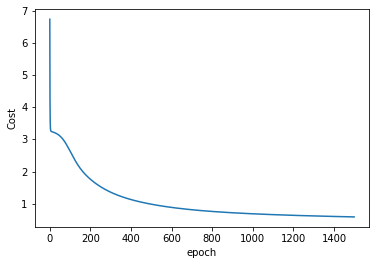

In [10]:
#梯度下降法进行训练
#由于scipy优化库的api接口要求的决策变量Theta必须为一维向量，且形式要求严格
#本次之间使用循环的梯度下降法来验证
def train(X,y,Epoch,lr,l=1):
    #随机初始化
    theta1 = np.random.uniform(-0.12,0.12,(25,401))
    theta2 = np.random.uniform(-0.12,0.12,(10,26))
    Theta = [theta1,theta2]  #注意整个模型的参数都是以列表的形式进行保存的!
    Cost = [] #利用列表记录损失函数

    #循环进行梯度下降
    for epoch in range(Epoch):
        Cost.append(regularizedCost(Theta,X,y))
        delta1,delta2 = regularizedGradient(Theta,X,y)
        Theta[0] -= lr * delta1
        Theta[1] -= lr * delta2
        if (epoch%200) == 0:
            print('第%d轮训练的损失为: %.4f' %(epoch+1,Cost[-1]))
        
    plt.plot(Cost)
    plt.xlabel('epoch')
    plt.ylabel('Cost')
    plt.show()
    return Theta

trainTheta = train(X,y,1500,0.3)  

In [11]:
#验证训练的模型在训练集上的准确率如何
def test(trainTheta,X,y):
    a1, z2, a2, z3, h = forward(trainTheta,X)
    y_pre = np.argmax(h,axis=1) + 1
    print(classification_report(y,y_pre))

test(trainTheta,X,y_raw)


              precision    recall  f1-score   support

           1       0.93      0.98      0.95       500
           2       0.93      0.88      0.91       500
           3       0.92      0.90      0.91       500
           4       0.91      0.95      0.93       500
           5       0.92      0.89      0.90       500
           6       0.94      0.97      0.95       500
           7       0.94      0.93      0.94       500
           8       0.92      0.92      0.92       500
           9       0.92      0.91      0.92       500
          10       0.95      0.98      0.97       500

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



## 4.可视化隐藏层的参数

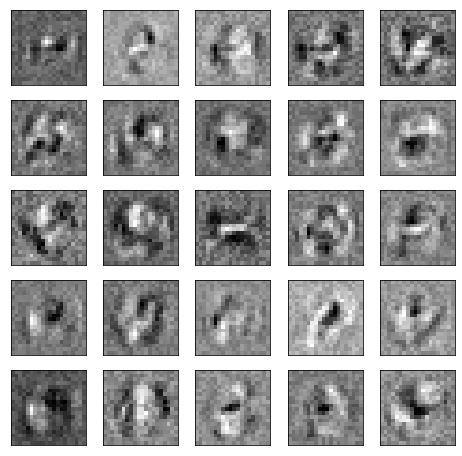

In [12]:
def showHiddenLayer(trainTheta):
    trainTheta1 = trainTheta[0][:,1:] #(25*400)
    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(trainTheta1[5 * r + c].reshape((20, 20)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()
    return None

showHiddenLayer(trainTheta)

## 4.总结

* 没有使用Scipy自带的优化算法，使用自己的的循环完成梯度下降法效果可能不是太好；
* 没有进行梯度检验；
* 后期可以尝试将全连接层封装成一个类，里面具有前向和反向传播的方法。